![title](header.png)

Autor: Junior Oliveira Mendes

Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import folium
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import openpyxl
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows

import geopandas as gpd
from shapely.geometry import Point
from math import radians, cos, sin, sqrt, atan2

# Filtro de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Carrega o arquivo Excel que servirá de base para captura das informações
file_path = 'Sequenciamento operação.xlsx'

Primeiramente, como a dimensão das colunas está diretamente relacionada ao número de períodos, vamos capturar as datas e o período que ela representa (de 1 a n).

In [2]:
sheet_name = 'Capacidade de Produção'

# Carregar dados da planilha especificada
periodos = pd.read_excel(file_path, sheet_name=sheet_name, usecols="B:C", header=4)

# Remover linhas vazias
periodos.dropna(inplace=True)

# Converter a coluna 'Período' para tipo inteiro
periodos['Período'] = periodos['Período'].astype(int)

# Exibir dataframe para verificação
periodos

Período       Data
0         1 2024-07-01
1         2 2024-08-01
2         3 2024-09-01
3         4 2024-10-01
4         5 2024-11-01
5         6 2024-12-01
6         7 2025-01-01
7         8 2025-02-01
8         9 2025-03-01
9        10 2025-04-01
10       11 2025-05-01
11       12 2025-06-01
12       13 2025-07-01
13       14 2025-08-01
14       15 2025-09-01
15       16 2025-10-01
16       17 2025-11-01
17       18 2025-12-01

Importa as capacidades de produção por Módulo e Período

In [3]:
# Calcular o número de períodos para definir o range das colunas de capacidades
num_periods = len(periodos)

# Definir as colunas a serem lidas com base no número de períodos
col_range = f"F:{chr(70 + num_periods - 1)}"

# Carregar a aba "Capacidades" do Excel
capacidades = pd.read_excel(file_path, sheet_name=sheet_name, usecols=f"E,{col_range}", header=4)

# Exibir as primeiras linhas do dataframe "Capacidades" para verificação
capacidades

Módulo      1      2      3      4      5      6      7      8      9  \
0   MOD_01  64687  58701  64929  61926  57137  55483  50656  63560  54560   
1   MOD_02  50291  58973  64384  61160  62749  58820  62736  60864  54189   
2   MOD_03  57234  51025  52882  50326  54840  61768  62294  53465  52135   
3   MOD_04  50548  54010  51868  52498  61050  51331  56187  61639  63561   
4   MOD_05  59591  58788  59528  54951  50899  63967  52440  57858  61754   
5   MOD_06  52856  60656  59226  58162  50482  58583  51061  64702  63135   
6   MOD_07  64464  64733  53744  50276  60369  53802  57279  62390  54305   
7   MOD_08  50144  58313  60519  61749  61775  58134  64002  53193  53034   
8   MOD_09  51803  52641  54581  61525  58069  63753  50179  56560  51926   
9   MOD_10  57146  54510  50861  62739  60920  63451  61663  58661  58317   
10  MOD_11  57094  52902  62977  60856  63210  59506  63978  63606  50769   
11  MOD_12  58260  54130  58034  52385  53308  60822  57455  62438  61733   
12  MOD_13  54335  53166  60308  64065  59397  56850  63135  64331  51608   
13  MOD_14  63046  54142  63869  52969  63730  53515  64773  55963  54635   
14  MOD_15  59811  61352  56426  58992  50249  59395  64152  61877  62332   
15  MOD_16  52886  63801  56486  63223  55832  53210  63430  58523  56910   
16  MOD_17  58645  58143  59471  52829  51405  64868  56797  50311  57520   
17  MOD_18  56545  53892  57548  63248  52255  53860  53707  64527  51495   
18  MOD_19  61965  53250  61563  57539  53993  64359  61555  55881  59554   
19  MOD_20  60666  64975  57758  53661  57143  56442  62459  64046  50650   

       10     11     12     13     14     15     16     17     18  
0   59107  58116  62691  56599  58799  59853  50782  53740  64746  
1   55618  57891  54244  61829  55693  61981  61525  54145  55829  
2   52579  61651  57374  53037  57050  57792  56617  60928  52864  
3   52547  57806  64710  61528  61854  62130  51892  58945  59551  
4   59279  51684  50474  64340  62873  61349  63469  50989  55813  
5   60145  51528  58635  62856  60902  60174  59375  62825  53814  
6   56402  60409  51591  61572  55410  54233  59284  62947  59283  
7   56565  54650  56654  62271  64791  62399  64576  53650  57281  
8   52445  50298  63253  61871  56959  57162  52452  61784  60459  
9   52507  60085  50707  59358  59282  51101  63582  62851  63065  
10  61957  60102  63812  54053  54585  63721  54970  64534  50624  
11  63409  60252  57328  57884  59939  50879  58397  52420  60897  
12  63200  55782  58572  50230  56057  61845  54546  50587  50754  
13  57240  51163  53232  64680  55653  52405  58760  60207  57408  
14  60499  54343  62664  62825  56486  64031  54100  60706  50575  
15  56838  54077  53749  55238  63178  63226  62963  52772  51361  
16  54348  53161  54885  56171  59080  53107  64770  62242  51254  
17  62666  57263  63542  62805  55143  54096  56330  59793  54754  
18  54773  56363  57056  52402  59700  53859  61413  59321  59574  
19  54960  53065  58544  53177  50104  60726  53448  59710  53467

Importa a base de Inventário Florestal

In [4]:
sheet_name = 'Inventário'

# Carregar dados da planilha especificada
Inventário = pd.read_excel(file_path, sheet_name=sheet_name, usecols="B:J", header=4)

# Remover linhas vazias
Inventário.dropna(inplace=True)

# Converter a coluna 'Período' para tipo inteiro
Inventário['Periodo Inicial'] = Inventário['Periodo Inicial'].astype(int)

# Exibir as primeiras linhas do dataframe para verificação
Inventário

Periodo Inicial  Talhão Bloco Genero  Volume_atual  \
0                   1  AAFD1K   AAA    EUC         22278   
1                   1  AAIK3U   AAA    EUC         26306   
2                   1  AAQC1S   AAA    PIN         19258   
3                   1  AARS8I   AAA    PIN         19036   
4                   1  AATK1M   AAA    PIN         33094   
...               ...     ...   ...    ...           ...   
1495                1  ZWBQ7S   ZWZ    PIN         18872   
1496                1  ZWRR6P   ZWZ    EUC         20802   
1497                1  ZXAY4N   ZXZ    EUC          6477   
1498                1  ZYHK7M   ZYZ    PIN         19740   
1499                1  ZZUB3S   ZZZ    EUC         16367   

      Volume_atual + 6 meses  Volume_atual + 12 meses       Lat.      Long.  
0                      22946                    23176 -24.049144 -50.701538  
1                      27095                    27366 -24.051874 -50.694294  
2                      19836                    20034 -24.056070 -50.685086  
3                      19607                    19803 -24.060474 -50.694258  
4                      34087                    34428 -24.064565 -50.682390  
...                      ...                      ...        ...        ...  
1495                   19438                    19633 -23.792181 -50.646230  
1496                   21426                    21640 -23.791254 -50.685750  
1497                    6671                     6738 -23.791518 -50.673628  
1498                   20332                    20536 -23.794757 -50.656849  
1499                   16858                    17027 -23.794333 -50.675626  

[1500 rows x 9 columns]

Shapefiles podem ser baixados no endereço: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html

In [5]:
# Carrega o shapefile dos municípios do Brasil
municipios = gpd.read_file("BR_Municipios_2022.shp", encoding='utf-8')

Inventário['geometry'] = Inventário.apply(lambda row: Point(float(row['Long.']), float(row['Lat.'])), axis=1)
gdf_Inventário = gpd.GeoDataFrame(Inventário, geometry='geometry')

# Garantia de que os GeoDataFrames estão usando o mesmo CRS (Coordinate Reference System)
gdf_Inventário.crs = municipios.crs

# Realiza o spatial join
Inventário_com_localizacao = gpd.sjoin(gdf_Inventário, municipios, how="left", op='intersects')

# Seleciona as colunas de interesse. No shapefile utilizado a coluna Município possui o nome 'NM_MUN' e o estado 'SIGLA_UF'
Inventário['Município'] = Inventário_com_localizacao['NM_MUN']
Inventário['Estado'] = Inventário_com_localizacao['SIGLA_UF']

Inventário.drop(columns='geometry', inplace=True)

# Dataframe de Inventário agora possui os nomes do Município e do Estado de cada talhão da base
Inventário

Periodo Inicial  Talhão Bloco Genero  Volume_atual  \
0                   1  AAFD1K   AAA    EUC         22278   
1                   1  AAIK3U   AAA    EUC         26306   
2                   1  AAQC1S   AAA    PIN         19258   
3                   1  AARS8I   AAA    PIN         19036   
4                   1  AATK1M   AAA    PIN         33094   
...               ...     ...   ...    ...           ...   
1495                1  ZWBQ7S   ZWZ    PIN         18872   
1496                1  ZWRR6P   ZWZ    EUC         20802   
1497                1  ZXAY4N   ZXZ    EUC          6477   
1498                1  ZYHK7M   ZYZ    PIN         19740   
1499                1  ZZUB3S   ZZZ    EUC         16367   

      Volume_atual + 6 meses  Volume_atual + 12 meses       Lat.      Long.  \
0                      22946                    23176 -24.049144 -50.701538   
1                      27095                    27366 -24.051874 -50.694294   
2                      19836                    20034 -24.056070 -50.685086   
3                      19607                    19803 -24.060474 -50.694258   
4                      34087                    34428 -24.064565 -50.682390   
...                      ...                      ...        ...        ...   
1495                   19438                    19633 -23.792181 -50.646230   
1496                   21426                    21640 -23.791254 -50.685750   
1497                    6671                     6738 -23.791518 -50.673628   
1498                   20332                    20536 -23.794757 -50.656849   
1499                   16858                    17027 -23.794333 -50.675626   

                  Município Estado  
0            Telêmaco Borba     PR  
1            Telêmaco Borba     PR  
2            Telêmaco Borba     PR  
3            Telêmaco Borba     PR  
4            Telêmaco Borba     PR  
...                     ...    ...  
1495  São Jerônimo da Serra     PR  
1496  São Jerônimo da Serra     PR  
1497  São Jerônimo da Serra     PR  
1498  São Jerônimo da Serra     PR  
1499  São Jerônimo da Serra     PR  

[1500 rows x 11 columns]

Importa a lista de talhões por ordem de sequenciamento por Módulo

In [6]:
sheet_name = 'Sequenciamento manual'

# Carregar dados da planilha especificada
Sequenciamento = pd.read_excel(file_path, sheet_name=sheet_name, usecols="B:CX", header=4)

# Substituir valores nulos por uma string vazia nas colunas de C até CX
for col in Sequenciamento.columns[2:]:  # Ignora as duas primeiras colunas (B e C)
    Sequenciamento[col] = Sequenciamento[col].fillna('N/A')

# Exibir as primeiras linhas do dataframe para verificação
Sequenciamento

Módulo       1       2       3       4       5       6       7       8  \
0   MOD_01  AAFD1K  AAIK3U  AAQC1S  AARS8I  AATK1M  AAWR3Z  AAXM3R  ABCJ4F   
1   MOD_02  BDVA7Z  BEAU8Y  BEKA3A  BEXN3V  BFHH8E  BFJA9P  BHHI3S  BIOU4V   
2   MOD_03  CQTJ9E  CRDC5Z  CRTB7J  CSKU3A  CSSG4V  CSYV6I  CTCJ7I  CUTU4X   
3   MOD_04  DXZP4S  DYCW9Z  DYHS2B  DYOT3X  DZPE3E  DZYM7R  EAHD8I  EAWX3I   
4   MOD_05  FDHE6H  FERA6O  FFIM6W  FFQA2L  FFRW8V  FGIL1T  FHBR2B  FHNE3M   
5   MOD_06  GQAA8C  GTBR5T  GTBT1Q  GTFZ2U  GUDC3F  GVDE4L  GVTD5L  GWFL2H   
6   MOD_07  ICAN3V  ICQN4K  IDEU9A  IDIV4D  IDIW9F  IFDQ6Q  IFHB8M  IFIN7A   
7   MOD_08  JOYO6E  JPZO7D  JQMW1Y  JQOL1P  JQYO5L  JSDI5Z  JSVW8K  JSYO8V   
8   MOD_09  KXXJ8I  KYKT5Y  KYPX4J  KYQS1X  KYWG8J  KZJT3G  LAIG3D  LALS5T   
9   MOD_10  MFCA7Z  MFIB8V  MFID5T  MFMD1Y  MFNA5R  MFOU5R  MGCE3G  MHLB2H   
10  MOD_11  NRWK5H  NSBH8S  NSMZ4G  NSTR8F  NTUN9Y  NUHU3G  NUNU6T  NVTK4A   
11  MOD_12  PBPD2L  PBRW5G  PCAY2Y  PCMS8K  PCNM9B  PCRR5W  PCTF7V  PCYK3Y   
12  MOD_13  QGJV4R  QGVZ9Z  QHDC9K  QHND7H  QIKU8L  QJET9W  QKGK1W  QLDN2E   
13  MOD_14  RNUP3H  RORV3W  RPHU8Q  RPHZ7Q  RPTI7O  RPVB8V  RQFZ3Y  RQQA7H   
14  MOD_15  SUML7C  SUOA4J  SUTH6W  SVAQ5L  SVMP3M  SVQS2G  SWEB4V  SWMO7M   
15  MOD_16  TZXE4D  UBDB1N  UCWK3Q  UDKT5F  UDVK8J  UEKF6Q  UFFG2P  UFFL2E   
16  MOD_17  VIOV4C  VKQZ9U  VLKY3T  VLQS5P  VLVE7N  VMTF2C  VNKW3H  VNQS2T   
17  MOD_18  WLJN6I  WLOU6F  WMNR5O  WMSA4S  WMVE1A  WOKF9P  WOMJ9H  WOTI5N   
18  MOD_19  XRPE8H  XRWQ7R  XSCO5W  XSLS7V  XSRR2X  XSUA1H  XTFW9V  XTYA2V   
19  MOD_20  YRAG8U  YRNT8Q  YROO8T  YSSW9M  YSYQ5N  YTKC4Q  YTOM7D  YUOI1P   

         9  ...   91   92   93   94   95   96   97   98   99  100  
0   ABVU4M  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
1   BIOU6F  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
2   CVFA9J  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
3   EBCT8G  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
4   FHXN5K  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
5   GXBA8X  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
6   IFWX9B  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
7   JTSO9L  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
8   LBHF7Q  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
9   MHWX7D  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
10  NWEA5P  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
11  PCZD3L  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
12  QLLF9S  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
13  RQVY7N  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
14  SWNE7B  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
15  UFWB1L  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
16  VOEZ6A  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
17  WOTJ4D  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
18  XUFR4K  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  
19  YVNL6W  ...  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  N/A  

[20 rows x 101 columns]

### Distribuindo o sequenciamento por Módulo e Período

In [7]:
# Definição das colunas do DataFrame resultados
resultados_cols = ['Período', 'Data', 'Módulo', 'Talhão', 'Bloco', 'Gênero', 'Volume', 'Lat.', 'Long.', 'Município', 'Estado', 'Alertas']
resultados = pd.DataFrame(columns=resultados_cols)

# Função para obter o volume com base no período
def calcular_volume(talhao, periodo_index):
    linha = Inventário[Inventário['Talhão'] == talhao]
    if periodo_index < 7:
        return linha['Volume_atual'].values[0]
    elif 7 <= periodo_index < 13:
        return linha['Volume_atual + 6 meses'].values[0]
    else:
        return linha['Volume_atual + 12 meses'].values[0]

# Dicionário para rastrear o volume restante de cada talhão
talhoes_rest_volume = {}

# Processamento principal - Distribuição do volume com base na capacidade máxima do módulo por período
for index, row in capacidades.iterrows():
    modulo = row['Módulo']
    talhoes_sequenciados = Sequenciamento[Sequenciamento['Módulo'] == modulo].iloc[0, 1:].tolist()
    next_period_talhoes = []

    for periodo_index, capacidade_periodo in enumerate(row[1:], 1):
        data_periodo = periodos[periodos['Período'] == periodo_index]['Data'].iloc[0]
        # Prioriza talhões com volume restante do período anterior
        talhoes_sequenciados = next_period_talhoes + talhoes_sequenciados
        next_period_talhoes = []

        while capacidade_periodo > 0 and talhoes_sequenciados:
            talhao = talhoes_sequenciados.pop(0).strip()
            if talhao == 'N/A':
                continue

            if talhao not in talhoes_rest_volume:
                talhoes_rest_volume[talhao] = calcular_volume(talhao, periodo_index)

            volume_to_use = min(talhoes_rest_volume[talhao], capacidade_periodo)
            talhoes_rest_volume[talhao] -= volume_to_use
            capacidade_periodo -= volume_to_use

            alerta = 'Volume restante transbordado para o próximo período' if talhoes_rest_volume[talhao] > 0 else ''
            resultados = pd.concat([resultados, pd.DataFrame({
                'Período': periodos[periodos['Período'] == periodo_index]['Período'].iloc[0],
                'Data': [data_periodo],
                'Módulo': [modulo],
                'Talhão': [talhao],
                'Bloco': [Inventário[Inventário['Talhão'] == talhao]['Bloco'].values[0]],
                'Gênero': [Inventário[Inventário['Talhão'] == talhao]['Genero'].values[0]],
                'Volume': [volume_to_use],
                'Lat.': [Inventário[Inventário['Talhão'] == talhao]['Lat.'].values[0]],
                'Long.': [Inventário[Inventário['Talhão'] == talhao]['Long.'].values[0]],
                'Município': [Inventário[Inventário['Talhão'] == talhao]['Município'].values[0]],
                'Estado': [Inventário[Inventário['Talhão'] == talhao]['Estado'].values[0]],
                'Alertas': [alerta]
            }, columns=resultados_cols)], ignore_index=True)
            
            # Insere no início para processar primeiro no próximo período
            if talhoes_rest_volume[talhao] > 0:
                next_period_talhoes.insert(0, talhao)  

resultados['Data'] = pd.to_datetime(resultados['Data']).dt.strftime('%d/%m/%Y')
resultados

Período        Data  Módulo  Talhão Bloco Gênero Volume       Lat.  \
0          1  01/07/2024  MOD_01  AAFD1K   AAA    EUC  22278 -24.049144   
1          1  01/07/2024  MOD_01  AAIK3U   AAA    EUC  26306 -24.051874   
2          1  01/07/2024  MOD_01  AAQC1S   AAA    PIN  16103 -24.056070   
3          2  01/08/2024  MOD_01  AAQC1S   AAA    PIN   3155 -24.056070   
4          2  01/08/2024  MOD_01  AARS8I   AAA    PIN  19036 -24.060474   
...      ...         ...     ...     ...   ...    ...    ...        ...   
1344      17  01/11/2025  MOD_20  ZLYU6N   ZLZ    EUC  27440 -23.753015   
1345      18  01/12/2025  MOD_20  ZLYU6N   ZLZ    EUC   5533 -23.753015   
1346      18  01/12/2025  MOD_20  ZMEO1B   ZMZ    EUC  10602 -23.758901   
1347      18  01/12/2025  MOD_20  ZMVC4U   ZMZ    PIN  24494 -23.763698   
1348      18  01/12/2025  MOD_20  ZNBA6O   ZNZ    PIN  12838 -23.764105   

          Long.              Município Estado  \
0    -50.701538         Telêmaco Borba     PR   
1    -50.694294         Telêmaco Borba     PR   
2    -50.685086         Telêmaco Borba     PR   
3    -50.685086         Telêmaco Borba     PR   
4    -50.694258         Telêmaco Borba     PR   
...         ...                    ...    ...   
1344 -50.609984  São Jerônimo da Serra     PR   
1345 -50.609984  São Jerônimo da Serra     PR   
1346 -50.613688  São Jerônimo da Serra     PR   
1347 -50.615181  São Jerônimo da Serra     PR   
1348 -50.620028  São Jerônimo da Serra     PR   

                                                Alertas  
0                                                        
1                                                        
2     Volume restante transbordado para o próximo pe...  
3                                                        
4                                                        
...                                                 ...  
1344  Volume restante transbordado para o próximo pe...  
1345                                                     
1346                                                     
1347                                                     
1348  Volume restante transbordado para o próximo pe...  

[1349 rows x 12 columns]

In [8]:
# Inicializar DataFrame 'n_mudancas' com as colunas necessárias
n_mudancas_cols = ['Módulo', 'Data', 'Origem', 'Destino']
n_mudancas = pd.DataFrame(columns=n_mudancas_cols)

# Variável para armazenar o último bloco visto por módulo
ultimo_bloco_por_modulo = {}

for index, row in resultados.iterrows():
    modulo = row['Módulo']
    data = row['Data']
    bloco_atual = row['Bloco']
    
    # Verificar se há uma mudança de bloco para o mesmo módulo
    if modulo in ultimo_bloco_por_modulo and ultimo_bloco_por_modulo[modulo] != bloco_atual:
        nova_mudanca = pd.DataFrame({
            'Módulo': [modulo],
            'Data': [data],
            'Origem': [ultimo_bloco_por_modulo[modulo]],
            'Destino': [bloco_atual]
        })
        # Adicionar a mudança ao DataFrame 'n_mudancas' usando concat
        n_mudancas = pd.concat([n_mudancas, nova_mudanca], ignore_index=True)
    
    # Atualizar o último bloco visto para o módulo atual
    ultimo_bloco_por_modulo[modulo] = bloco_atual

# Mostrar as mudanças de bloco detectadas
n_mudancas

Módulo        Data Origem Destino
0    MOD_01  01/09/2024    AAA     ABA
1    MOD_01  01/10/2024    ABA     ACA
2    MOD_01  01/11/2024    ACA     ADA
3    MOD_01  01/12/2024    ADA     AEA
4    MOD_01  01/01/2025    AEA     AGA
..      ...         ...    ...     ...
401  MOD_20  01/09/2025    ZIZ     ZJZ
402  MOD_20  01/10/2025    ZJZ     ZKZ
403  MOD_20  01/10/2025    ZKZ     ZLZ
404  MOD_20  01/12/2025    ZLZ     ZMZ
405  MOD_20  01/12/2025    ZMZ     ZNZ

[406 rows x 4 columns]

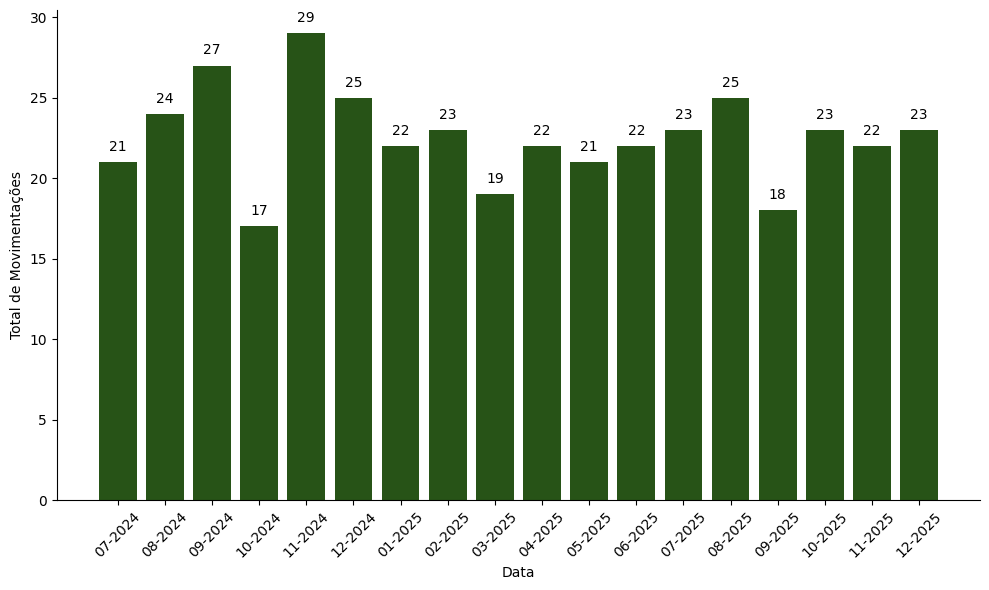

In [9]:
# As datas podem estar como string e precisamos convertê-las corretamente
n_mudancas['Data'] = pd.to_datetime(n_mudancas['Data'], format='%d/%m/%Y')

# Agrupar por mês e ano para contar o número de mudanças
mudancas_por_data = n_mudancas.groupby(n_mudancas['Data'].dt.to_period('M')).size().reset_index(name='Numero de Mudancas')
mudancas_por_data['Data'] = mudancas_por_data['Data'].dt.to_timestamp()

# Ordenar por data
mudancas_por_data.sort_values('Data', inplace=True)

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(mudancas_por_data['Data'].dt.strftime('%m-%Y'), mudancas_por_data['Numero de Mudancas'], color='#275317')

# Adicionar o total sobre as barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

# Adiconar títulos dos eixos
plt.xlabel('Data')
plt.ylabel('Total de Movimentações')
plt.xticks(rotation=45)

# Ajustar os eixos para remover as bordas superior e direita
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Salvar a imagem gerada
plt.savefig('movimentacoes.png')
plt.show()

In [10]:
# Função para calcular a distância Euclidiana entre dois pontos geográficos
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Convertendo graus em radianos
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Fórmula de Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Raio da Terra em km
    R = 6371.0
    return R * c

# Calcular a distância total percorrida por módulo e período
distancias_por_modulo_periodo = []

for modulo, grupo_modulo in resultados.groupby('Módulo'):
    for periodo, talhoes_periodo in grupo_modulo.groupby('Período'):
        total_distancia = 0
        # Inicializar o ponto anterior com o primeiro talhão do período
        prev_lat, prev_long = talhoes_periodo.iloc[0]['Lat.'], talhoes_periodo.iloc[0]['Long.']
        
        for _, talhao in talhoes_periodo.iterrows():
            lat, long = talhao['Lat.'], talhao['Long.']
            total_distancia += calcular_distancia(prev_lat, prev_long, lat, long)
            prev_lat, prev_long = lat, long  # Atualiza o ponto anterior
        
        distancias_por_modulo_periodo.append((modulo, periodo, total_distancia))

# Convertendo a lista em DataFrame
distancias_df = pd.DataFrame(distancias_por_modulo_periodo, columns=['Módulo', 'Período', 'Distância Total (km)'])

distancias_df

Módulo  Período  Distância Total (km)
0    MOD_01        1              1.840600
1    MOD_01        2             10.477221
2    MOD_01        3             25.669713
3    MOD_01        4             30.523233
4    MOD_01        5             25.823254
..      ...      ...                   ...
355  MOD_20       14              0.704760
356  MOD_20       15             15.586266
357  MOD_20       16             17.135562
358  MOD_20       17              1.368911
359  MOD_20       18              1.805299

[360 rows x 3 columns]

In [11]:
# Agrupar e somar as distâncias por período
distancias_totais_por_periodo = distancias_df.groupby('Período')['Distância Total (km)'].sum().reset_index()

# Renomeando as colunas para melhor clareza
distancias_totais_por_periodo.columns = ['Período', 'Distância Total Acumulada (km)']
distancias_totais_por_periodo['Distância Total Acumulada (km)'] = distancias_totais_por_periodo['Distância Total Acumulada (km)'].round(1)

# Exibindo o resultado
distancias_totais_por_periodo

Período  Distância Total Acumulada (km)
0         1                           177.5
1         2                           241.6
2         3                           398.9
3         4                           348.4
4         5                           397.3
5         6                           301.3
6         7                           327.5
7         8                           337.9
8         9                           350.1
9        10                           372.8
10       11                           334.0
11       12                           492.6
12       13                           528.9
13       14                           388.9
14       15                           426.7
15       16                           393.2
16       17                           472.8
17       18                           471.0

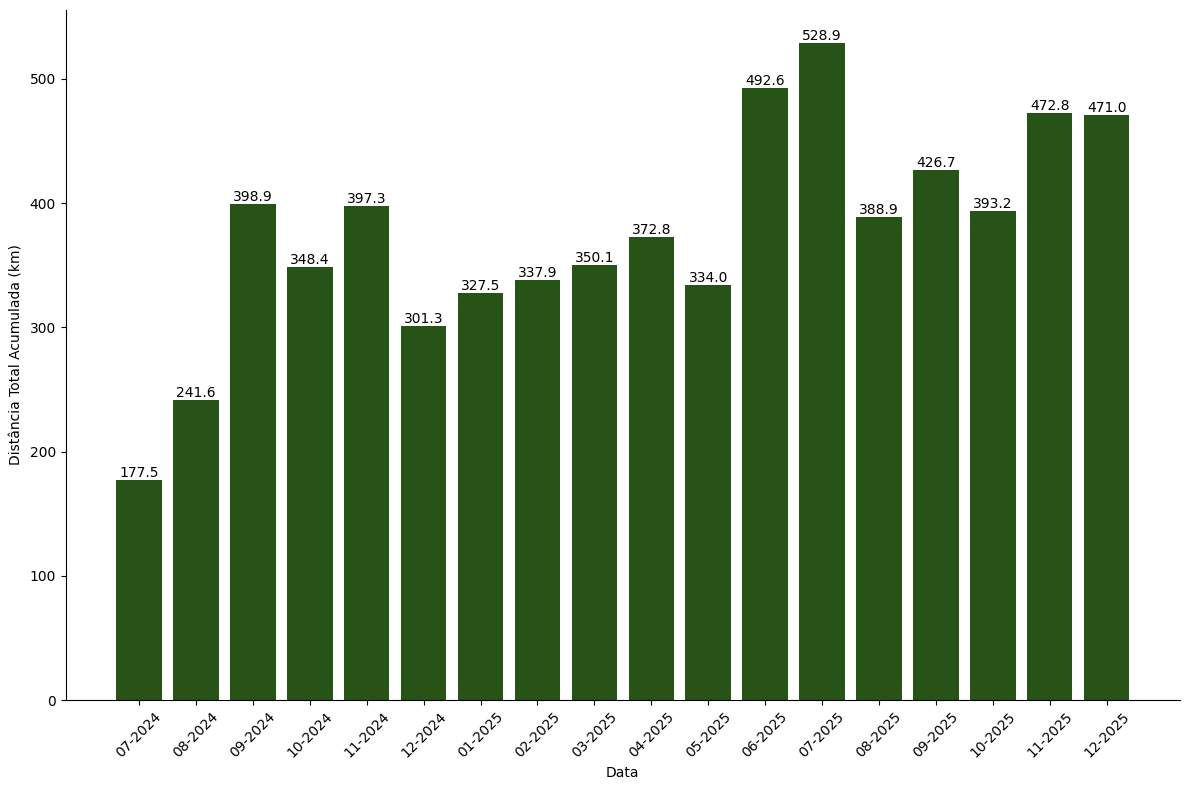

In [12]:
# Juntar as datas aos dados de distância
distancias_com_datas = distancias_totais_por_periodo.merge(periodos, on='Período')
distancias_com_datas['Data'] = pd.to_datetime(distancias_com_datas['Data']).dt.strftime('%m-%Y')

# Plotar o gráfico de barras
plt.figure(figsize=(12, 8))
bars = plt.bar(distancias_com_datas['Data'], distancias_com_datas['Distância Total Acumulada (km)'], color='#275317')

# Adicionar o total sobre as barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', ha='center', va='bottom', fontsize=10)

# Ajustar títulos dos eixos
plt.xlabel('Data')
plt.ylabel('Distância Total Acumulada (km)')
plt.xticks(rotation=45)

# Ajustar os eixos para remover as bordas superior e direita
ax = plt.gca()  # Obtém o eixo atual
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Salvar a imagem gerada
plt.savefig('distancia_total.png')

# Exibir o gráfico
plt.show()

In [13]:
# Inicializando o mapa com uma localização
mapa = folium.Map(location=[-25.093407783060655, -50.16295077543825], zoom_start=8)

# # Criar uma paleta de cores baseada no número de módulos únicos
num_modulos = len(capacidades)
try:
    colors = plt.cm.tab20b(np.linspace(0, 1, num_modulos))
except ValueError:
    # Se houver mais módulos do que cores disponíveis em 'tab20c', usa 'tab20c' e repete as cores
    base_colors = plt.cm.tab20c(np.linspace(0, 1, 20))  # 20 cores
    colors = np.tile(base_colors, (num_modulos // 20 + 1, 1))[:num_modulos]

modulo_to_color = {modulo: mcolors.to_hex(color) for modulo, color in zip(sorted(resultados['Módulo'].unique()), colors)}


# Adicionar marcadores ao mapa
for _, row in resultados.iterrows():
    # Formatar o popup com informações detalhadas
    popup_content = f'''
    <b>Módulo:</b> {row['Módulo']}<br>
    <b>Data:</b> {row['Data']}<br>
    <b>Bloco:</b> {row['Bloco']}<br>
    <b>Talhão:</b> {row['Talhão']}<br>
    <b>Gênero:</b> {row['Gênero']}<br>
    <b>Volume:</b> {row['Volume']}<br>
    <b>Período:</b> {row['Período']}<br>
    <b>Município:</b> {row['Município']}<br>
    <b>Estado:</b> {row['Estado']}<br>
    '''
    popup = folium.Popup(popup_content, max_width=250)
    # Usar a cor correspondente ao período em um Circle
    folium.Circle(
        location=[row['Lat.'], row['Long.']],
        radius=6,
        color=modulo_to_color[row['Módulo']],
        fill=True,
        fill_color=modulo_to_color[row['Módulo']],
        fill_opacity=0.6,
        popup=popup
    ).add_to(mapa)

# Construir uma legenda HTML dinâmica
legend_html = '<div style="position: fixed; bottom: 50px; right: 50px; width: 150px; height: auto; border:2px solid grey; z-index:9999; font-size:14px; padding: 5px; background: white;">'
legend_html += '<b>Módulo:</b><br>'
for modulo, color in modulo_to_color.items():
    legend_html += f'&nbsp; {modulo} &nbsp; <i style="background:{color};width:10px;height:10px;border-radius:50%;display:inline-block;"></i><br>'
legend_html += '</div>'

# Adicionar a legenda ao mapa
mapa.get_root().html.add_child(folium.Element(legend_html))

# Salvar o mapa em um arquivo HTML
mapa.save('Mapa_de_Talhoes_Modulos.html')
mapa

In [14]:
# Inicializar o mapa
mapaP = folium.Map(location=[-25.093407783060655, -50.16295077543825], zoom_start=8)

try:
    colors = plt.cm.tab20c(np.linspace(0, 1, num_periods))
except ValueError:
    base_colors = plt.cm.tab20c(np.linspace(0, 1, 20))  # 20 cores
    colors = np.tile(base_colors, (num_periods // 20 + 1, 1))[:num_periods]

periodo_to_color = {periodo: mcolors.to_hex(color) for periodo, color in zip(sorted(resultados['Período'].unique()), colors)}

# Adicionar marcadores ao mapa
for _, row in resultados.iterrows():

    # Formatar o popup com informações detalhadas
    popup_content = f'''
    <b>Módulo:</b> {row['Módulo']}<br>
    <b>Data:</b> {row['Data']}<br>
    <b>Bloco:</b> {row['Bloco']}<br>
    <b>Talhão:</b> {row['Talhão']}<br>
    <b>Gênero:</b> {row['Gênero']}<br>
    <b>Volume:</b> {row['Volume']}<br>
    <b>Período:</b> {row['Período']}<br>
    <b>Município:</b> {row['Município']}<br>
    <b>Estado:</b> {row['Estado']}<br>
    '''
    popup = folium.Popup(popup_content, max_width=250)
    folium.Circle(
        location=[row['Lat.'], row['Long.']],
        radius=8,
        color=periodo_to_color[row['Período']],
        fill=True,
        fill_color=periodo_to_color[row['Período']],
        fill_opacity=0.6,
        popup=popup
    ).add_to(mapaP)

# Construir uma legenda HTML dinâmica
legend_html = '<div style="position: fixed; bottom: 50px; right: 50px; width: 150px; height: auto; border:2px solid grey; z-index:9999; font-size:14px; padding: 5px; background: white;">'
legend_html += '<b>Período:</b><br>'
for periodo, color in periodo_to_color.items():
    legend_html += f'&nbsp; {periodo} &nbsp; <i style="background:{color};width:10px;height:10px;border-radius:50%;display:inline-block;"></i><br>'
legend_html += '</div>'

# Adicionar a legenda ao mapa
mapaP.get_root().html.add_child(folium.Element(legend_html))

# Salvar e mostrar o mapa
mapaP.save('Mapa_de_Talhoes_Periodo.html')
mapaP

#### Exporta resultados para o Excel

In [15]:
def exportar_resultados_para_excel(df, arquivo, aba, inicio_col, inicio_linha):
    # Verifica se o arquivo existe no diretório, se não, cria um novo
    if not os.path.isfile(arquivo):
        book = openpyxl.Workbook()
        sheet = book.active
        sheet.title = aba
    else:
        try:
            book = openpyxl.load_workbook(arquivo)
        except Exception as e:
            print(f"Erro ao abrir o arquivo: {e}")
            return
    
    if aba in book.sheetnames:
        sheet = book[aba]
        # Verificar se já existe uma imagem na posição desejada (simplificado por uma tag de controle)
        image_present = any(isinstance(obj, openpyxl.drawing.image.Image) for obj in sheet._images)
    else:
        sheet = book.create_sheet(aba)
        image_present = False

    for r_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), start=1):
        for c_idx, value in enumerate(row, start=1):
            sheet.cell(row=inicio_linha + r_idx, column=openpyxl.utils.column_index_from_string(inicio_col) + c_idx - 1).value = value

    # Adicionar imagem na aba 'Movimentações', verificando se já existe uma imagem
    if aba == "Movimentações" and not image_present:
        img = Image('movimentacoes.png')
        img.anchor = 'F6'
        sheet.add_image(img)
    
    # Adicionar imagem na aba 'Distâncias', verificando se já existe uma imagem
    if aba == "Distâncias" and not image_present:
        img = Image('distancia_total.png')
        img.anchor = 'H6'
        sheet.add_image(img)

    try:
        book.save(arquivo)
    except Exception as e:
        print(f"Erro ao salvar o arquivo: {e}")
    finally:
        book.close()

exportar_resultados_para_excel(n_mudancas, 'Sequenciamento operação.xlsx', 'Movimentações', "B", 4)
exportar_resultados_para_excel(resultados, 'Sequenciamento operação.xlsx', 'Resultados', "B", 4)
exportar_resultados_para_excel(distancias_df, 'Sequenciamento operação.xlsx', 'Distâncias', "B", 4)
exportar_resultados_para_excel(distancias_totais_por_periodo, 'Sequenciamento operação.xlsx', 'Distâncias', "F", 4)

print("Exportação concluída com sucesso!")

Exportação concluída com sucesso!


In [16]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Junior Oliveira Mendes" --iversions

Author: Junior Oliveira Mendes

matplotlib: 3.8.4
pandas    : 2.2.2
geopandas : 0.14.4
openpyxl  : 3.1.2
numpy     : 1.26.4
folium    : 0.16.0

